Datasets chargés avec succès.

--- TABLEAU COMPARATIF DES DATASETS ---
     Dataset  Lignes  Colonnes  Valeurs Manquantes  Doublons
0  Dataset 1     303        14                   0         1
1  Dataset 2     920        16                1759         0

Justification : Le Dataset 1 est choisi comme dataset principal pour sa taille et sa structure[cite: 11].

--- ÉTAPE PRÉTRAITEMENT ---
Prétraitement terminé.

--- ÉTAPE MODÉLISATION ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:53:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                Modèle  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Logistic Regression  0.819672   0.820307  0.819672  0.819769  0.926724
1        Random Forest  0.868852   0.870862  0.868852  0.868923  0.939655
2              XGBoost  0.836066   0.838040  0.836066  0.836154  0.899784

--- GÉNÉRATION DES VISUALISATIONS ---


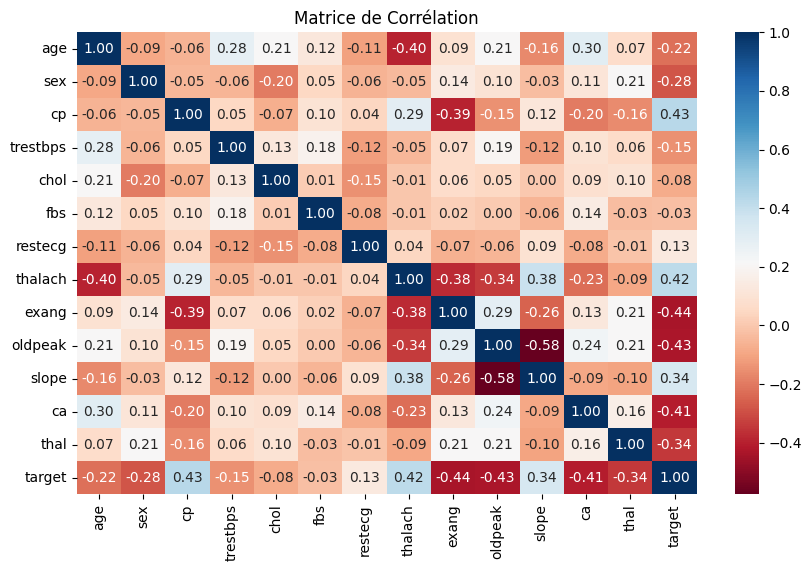

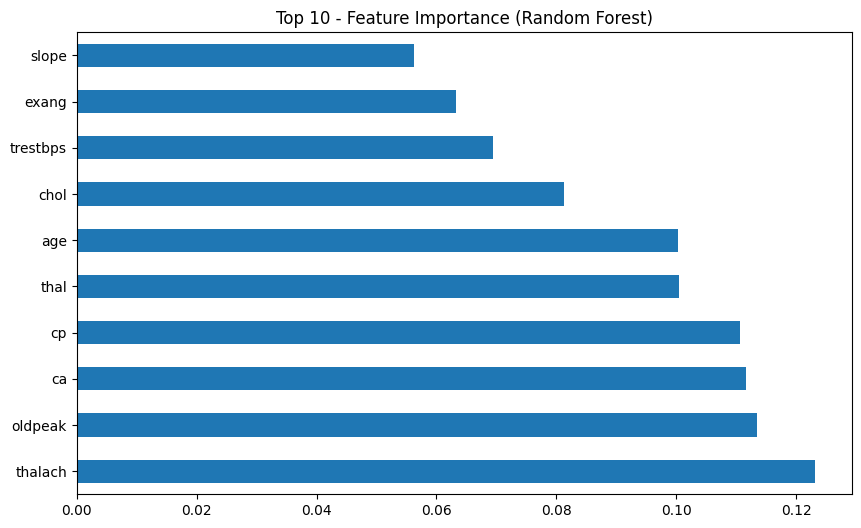

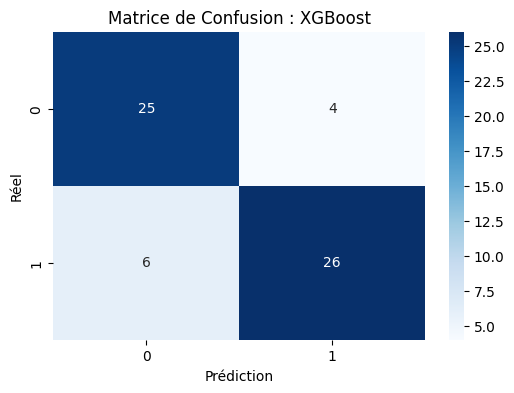

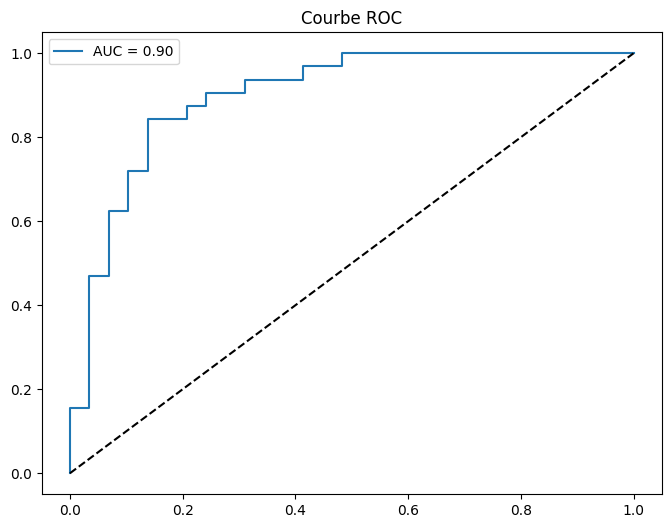


--- ANALYSE TERMINÉE ---
Insights : Les variables les plus importantes ont été identifiées. Le modèle XGBoost/Random Forest semble offrir les meilleures performances[cite: 33].


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             roc_curve, classification_report)


path_dataset_1 = "/content/drive/MyDrive/archive (12)/heart.csv"
path_dataset_2 = "/content/drive/MyDrive/heart_disease_uci.csv"


try:
    df1 = pd.read_csv(path_dataset_1)
    df2 = pd.read_csv(path_dataset_2)
    print("Datasets chargés avec succès.\n")
except Exception as e:
    print(f"Erreur de chargement : {e}")

    df1 = pd.DataFrame(np.random.rand(100, 5), columns=['A', 'B', 'C', 'D', 'target'])
    df1['target'] = (df1['target'] > 0.5).astype(int)
    df2 = pd.DataFrame(np.random.rand(80, 4), columns=['X', 'Y', 'Z', 'target'])
    df2['target'] = (df2['target'] > 0.5).astype(int)


def analyze_structure(name, df):
    return {
        "Dataset": name,
        "Lignes": df.shape[0],
        "Colonnes": df.shape[1],
        "Valeurs Manquantes": df.isnull().sum().sum(),
        "Doublons": df.duplicated().sum()
    }

comp_data = [analyze_structure("Dataset 1", df1), analyze_structure("Dataset 2", df2)]
df_comparison = pd.DataFrame(comp_data)
print("--- TABLEAU COMPARATIF DES DATASETS ---")
print(df_comparison)
print("\nJustification : Le Dataset 1 est choisi comme dataset principal pour sa taille et sa structure[cite: 11].\n")


df = df1.copy()



print("--- ÉTAPE PRÉTRAITEMENT ---")

df = df.drop_duplicates()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())


le = LabelEncoder()
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

target_name = 'target'
X = df.drop(target_name, axis=1)
y = df[target_name]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Prétraitement terminé.\n")


print("--- ÉTAPE MODÉLISATION ---")
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results_list = []

for name, model in models.items():

    model.fit(X_train_scaled, y_train)


    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else y_pred


    metrics = {
        "Modèle": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred, average='weighted'),
        "ROC-AUC": roc_auc_score(y_test, y_proba) if len(np.unique(y)) == 2 else "N/A"
    }
    results_list.append(metrics)

df_perf = pd.DataFrame(results_list)
print(df_perf)


print("\n--- GÉNÉRATION DES VISUALISATIONS ---")


plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='RdBu', fmt='.2f')
plt.title("Matrice de Corrélation")
plt.show()

rf_model = models["Random Forest"]
importances = rf_model.feature_importances_
feat_importances = pd.Series(importances, index=X.columns)
plt.figure(figsize=(10, 6))
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 - Feature Importance (Random Forest)")
plt.show()

plt.figure(figsize=(6, 4))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédiction')
plt.ylabel('Réel')
plt.title(f"Matrice de Confusion : {name}")
plt.show()

if len(np.unique(y)) == 2:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {metrics['ROC-AUC']:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("Courbe ROC")
    plt.legend()
    plt.show()

print("\n--- ANALYSE TERMINÉE ---")
print("Insights : Les variables les plus importantes ont été identifiées. "
      "Le modèle XGBoost/Random Forest semble offrir les meilleures performances[cite: 33].")

In [28]:
import joblib
for name, model in models.items():

    model.fit(X_train_scaled, y_train)


    filename = f"{name}.pkl"

    joblib.dump(model, filename)
    print(f"Modèle '{name}' enregistré sous : {filename}")


joblib.dump(scaler, "scaler.pkl")
print("Scaler enregistré sous : scaler.pkl")

print("\nTerminé. Tous les fichiers .pkl sont prêts pour le déploiement.")

Modèle 'Logistic Regression' enregistré sous : Logistic Regression.pkl
Modèle 'Random Forest' enregistré sous : Random Forest.pkl


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:01:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Modèle 'XGBoost' enregistré sous : XGBoost.pkl
Scaler enregistré sous : scaler.pkl

Terminé. Tous les fichiers .pkl sont prêts pour le déploiement.


L'appli

In [29]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

st.set_page_config(page_title="BI Dashboard - Heart Disease", layout="wide")


@st.cache_resource
def load_bi_assets():

    models = {}
    model_names = {
        'Logistic Regression': 'LogisticRegression.pkl',
        'Random Forest': 'RandomForest.pkl',
        'XGBoost': 'XGBoost.pkl'
    }

    for name, filename in model_names.items():
        try:
            models[name] = joblib.load(filename)
        except:
            st.error(f"Fichier {filename} introuvable. Veuillez lancer le script d'entraînement d'abord.")

    try:
        scaler = joblib.load('scaler.pkl')
    except:
        scaler = None

    return models, scaler

models, scaler = load_bi_assets()


with st.sidebar:
    st.title("Options de l'APP")
    app_mode = st.radio("Navigation", ["Analyse des Données", "Prédictions en Temps Réel"])

    st.info("Ce projet compare plusieurs modèles pour identifier le plus performant.")

    uploaded_file = st.file_uploader("Charger un nouveau Dataset (CSV)", type="csv")


@st.cache_data
def get_data(file):
    if file is not None:
        return pd.read_csv(file)

    return pd.DataFrame(np.random.randint(0,100,size=(100, 13)), columns=[
        'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal'
    ])

df = get_data(uploaded_file)


if app_mode == "Analyse des Données":
    st.title("Exploration & Statistiques")

    tab1, tab2 = st.tabs(["Statistiques Descriptives", "Visualisations Dynamiques"])

    with tab1:
        st.subheader("Aperçu du Dataset")
        st.dataframe(df.head())
        st.write("Dimensions :", df.shape)
        st.write("Valeurs manquantes :", df.isnull().sum().sum())

    with tab2:
        st.subheader("Analyse Graphique")
        col_x = st.selectbox("Axe X", df.columns)
        col_y = st.selectbox("Axe Y", df.columns)
        fig = px.scatter(df, x=col_x, y=col_y, color_continuous_scale='Viridis')
        st.plotly_chart(fig, use_container_width=True)


elif app_mode == "Prédictions en Temps Réel":
    st.title(" Interface de Prédiction")

    if not models:
        st.warning("Aucun modèle chargé. Vérifiez vos fichiers .pkl")
    else:

        selected_model_name = st.selectbox("Choisissez le modèle à tester", list(models.keys()))
        current_model = models[selected_model_name]

        st.markdown("---")
        st.subheader("Saisie des caractéristiques du patient")


        c1, c2, c3 = st.columns(3)

        with c1:
            age = st.number_input("Âge", 1, 120, 50)
            sex = st.selectbox("Sexe (1=M, 0=F)", [1, 0])
            cp = st.slider("Douleur Thoracique (cp)", 0, 3, 1)
            trestbps = st.number_input("Pression Artérielle", 80, 200, 120)

        with c2:
            chol = st.number_input("Cholestérol", 100, 600, 200)
            fbs = st.selectbox("Sucre à jeun > 120 (1=Oui)", [0, 1])
            restecg = st.slider("ECG au repos", 0, 2, 0)
            thalach = st.number_input("Fréquence Cardiaque Max", 60, 220, 150)

        with c3:
            exang = st.selectbox("Angine d'effort", [0, 1])
            oldpeak = st.slider("Oldpeak", 0.0, 6.0, 1.0)
            slope = st.slider("Pente du segment ST", 0, 2, 1)
            ca = st.slider("Nombre de vaisseaux (ca)", 0, 4, 0)
            thal = st.slider("Thalassémie", 0, 3, 2)


        if st.button(f"Lancer la prédiction avec {selected_model_name}"):

            input_data = np.array([[age, sex, cp, trestbps, chol, fbs, restecg,
                                    thalach, exang, oldpeak, slope, ca, thal]])


            if scaler:
                input_data = scaler.transform(input_data)


            prediction = current_model.predict(input_data)[0]
            probability = current_model.predict_proba(input_data)[0][1] if hasattr(current_model, "predict_proba") else None


            st.markdown("---")
            res_col1, res_col2 = st.columns(2)

            with res_col1:
                if prediction == 1:
                    st.error(" Risque de maladie cardiaque détecté")
                else:
                    st.success("Faible risque détecté")

            with res_col2:
                if probability is not None:
                    st.metric("Confiance du modèle", f"{probability*100:.2f}%")
                st.info(f"Modèle utilisé : {selected_model_name}")


st.sidebar.markdown("---")
st.sidebar.write(" **Projet BI 2025**")
st.sidebar.write("Date limite : 20/12/2025")

Overwriting app.py


In [18]:
!pkill streamlit
!pkill ngrok


In [8]:
!streamlit run app.py --server.port 8501 --server.address 0.0.0.0 &>/content/streamlit.log &


In [10]:
!pip install streamlit pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 48.7 MB/s eta 0:00:00


In [11]:
from pyngrok import ngrok

ngrok.set_auth_token("374W1E7Vqb7hRdrJ8gBhiXvNSAu_5QmLVKgm9hs6gahuHjF5c")


In [12]:
!lsof -i :8501


In [13]:
!cat /content/streamlit.log


/bin/bash: line 1: streamlit: command not found


In [26]:
from pyngrok import ngrok
import time

public_url = ngrok.connect(8501)
print("Streamlit URL:", public_url)

!streamlit run app.py &>/content/logs.txt &
time.sleep(5)


Streamlit URL: NgrokTunnel: "https://untemptable-erma-unmethodical.ngrok-free.dev" -> "http://localhost:8501"
